# A look at the current state of Sydney's AirBNB situation




## Emilio Guevarra Churches - z5311027
## Github - emiliog-c

A basic rundown on what this notebook/presentation is going to be looking at:
* How many AirBNBs are in Sydney in general
* Does location from the main attractions of a city actually determine the price or popularity? (Investigated by the distance of the AirBNB from Central Station)
* The pricing nature of AirBNBs and the cutthroat nature of the whole system.
* How some AirBNB hosts totally dominate the market
* How popular some suburbs/neighbourhoods are in comparison to others, and where would it be worth to invest in?

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import math
from numpy import cos, sin, arcsin, sqrt
from math import radians
import numpy as np
import pandas as pd
import os
import geopandas as gpd
from traitlets.config.manager import BaseJSONConfigManager
from pathlib import Path
path = Path.home() / ".jupyter" / "nbconfig"
cm = BaseJSONConfigManager(config_dir=str(path))
cm.update(
    "rise",
    {
        "theme": "sky",
        "transition": "zoom",
        "start_slideshow_at": "selected",      
        "scroll": "true",
        "enable_chalkboard": "true",
        "width": "65%",
        "height": "65%",
        
        
     }
)


{'theme': 'sky',
 'transition': 'zoom',
 'start_slideshow_at': 'selected',
 'scroll': 'true',
 'enable_chalkboard': 'true',
 'width': '65%',
 'height': '65%'}

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 10)

In [3]:
saved_style_state = matplotlib.rcParams.copy() #Style States

All the imports and stylestates needed for this notebook. You may recognise some.

In [4]:
if os.path.isfile("listings_data.csv") & os.path.isfile("neighbourhoods.geojson"):
    filepath = "listings_data.csv"
    mappath = "neighbourhoods.geojson"
    print("Loading from Local Files")
else:
    filepath = "http://data.insideairbnb.com/australia/nsw/sydney/2020-06-11/visualisations/listings.csv"
    mappath = "http://data.insideairbnb.com/australia/nsw/sydney/2020-06-11/visualisations/neighbourhoods.geojson"
    print("Loading from http://insideairbnb.com/get-the-data.html")

listdata = pd.read_csv(filepath)
df_places = gpd.read_file(mappath)
print("Successfully loaded listing CSV")

Loading from Local Files
Successfully loaded listing CSV


Loads the data used for all the graphs, if you don't have it, the notebook will load from the insideairbnb.com site. At this current moment, we're just looking at the Sydney AirBNB CSV as thats what I am most comfortable with, but all this code can easily be translated to be used with other places.

### Setting up the dataframe


Heres an example of the data we're working with. It's quite chunky, and theres a lot of useless data that we don't need.

In [5]:
listdata.head(3)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,11156,An Oasis in the City,40855,Colleen,NaN,Sydney,-33.86917,151.22656,Private room,64,2,196,2020-03-13,1.53,1,364
1,12351,Sydney City & Harbour at the door,17061,Stuart,NaN,Sydney,-33.86515,151.19190,Private room,14314,2,526,2019-09-22,4.37,2,0
2,14250,Manly Harbour House,55948,Heidi,NaN,Manly,-33.80093,151.26172,Entire home/apt,471,5,2,2019-01-02,0.04,2,173


In [6]:
row_one = listdata.iloc[1456]
row_one

id                                                          3492467
name                              Cozy & Sun-filled beach apartment
host_id                                                    17586718
host_name                                                    Sylvia
neighbourhood_group                                             NaN
neighbourhood                                              Waverley
latitude                                                   -33.8773
longitude                                                   151.273
room_type                                           Entire home/apt
price                                                           200
minimum_nights                                                    5
number_of_reviews                                                 8
last_review                                              2017-10-02
reviews_per_month                                              0.14
calculated_host_listings_count                  

An example of what one entry of the CSV looks like. The price refers to the nightly cost i.e. it costs $200 to stay in this AirBNB for one night. The calculated_host_listings_count refers to the amount of AirBNBs the host is currently hosting, while Availability_365 refers to when the place is able to be booked

We're going to add a new column, which considers the distance from the AirBNB to Central Station using the Haversine Method.

In [7]:
def haversine(row):
    lon1 = 151.2070
    lat1 = -33.8832
    lon2 = row['longitude']
    lat2 = row['latitude']
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a)) 
    km = 6367 * c
    return km

listdata['distance'] = listdata.apply(lambda row: haversine(row), axis=1)
dist_list = listdata.sort_values(by=["reviews_per_month"], ascending=True)
dist_list['number_of_reviews'] = pd.to_numeric(dist_list['number_of_reviews'].astype(str).str[:-1], errors = 'coerce') 
dist_list.head(3)


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,distance
1222,2840465,5 Bedroom House in Willoughby NSW,13837615,Kath And Jamie,NaN,Willoughby,-33.80543,151.20351,Entire home/apt,641,6,NaN,2014-12-20,0.01,1,0,8.648201
748,1893048,Lovely 2 br Bondi Beach Apartment,9839303,Sonal,NaN,Waverley,-33.88298,151.27204,Entire home/apt,220,10,NaN,2014-01-06,0.01,2,0,6.000217
1277,3006584,Point Piper Haven - Stunning Views,15322954,Alexandra,NaN,Woollahra,-33.86445,151.25029,Entire home/apt,300,5,NaN,2014-06-10,0.01,1,0,4.504898


In [8]:
row_one = dist_list.iloc[1456]
row_one

id                                                           21636607
name                              Bondi Beach Oasis - 1 Bed + Sunroom
host_id                                                      57599065
host_name                                                      Marion
neighbourhood_group                                               NaN
neighbourhood                                                Waverley
latitude                                                     -33.8889
longitude                                                     151.275
room_type                                             Entire home/apt
price                                                             157
minimum_nights                                                      7
number_of_reviews                                                 NaN
last_review                                                2018-01-06
reviews_per_month                                                0.03
calculated_host_list

This calculates the straight line distance between Central Station and the AirBNB using the Haversine formula, which calculates the distance across a spherical plane.
This means that if you input the locations in Google maps, you'll generally get a higher value due to it pathing through streets and roads.

#### Why am I using the distance to Central as my measure of distance?
When I'm searching for an AirBNB, especially in a foreign country for example, I'm usually searching for one closest to all the major tourism attractions that I am interested in. Where are most of Sydney's major tourist attractions? Around the CBD, and the mecca of transportation is in Central Station, thus allowing me to easily gauge how tourists look at what AirBNB is suitable for them.

We're also going to remove any data that cannot be booked at this current moment or if it hasn't had any reviews past July 6th, 2019, which means a lot of older listings are going to be removed.

Theres a lot of older listings that havent actually been booked in a while and it makes me unsure if they're actually able to be booked.
* Going to cull all the listings that haven't been reviewed in the past year 
* If their availability_365 is 0, since they are unable to be booked at all.
* We're also going to remove the neighbourhood_group column for clarities sake

In [9]:
ab = dist_list.dropna(subset=['last_review'])
ad = ab.sort_values(by="last_review")
ad
ag = ad[(ad['last_review'] > '2019-06-06') & (ad['last_review'] < '2020-06-12')] # Use this to change the time frame allowed, with the format of (FROM DATE - TO DATE), note if you go over the limits it will probably bug, so comment this out and look for the final date using the code above
ag = ag.drop(columns=['neighbourhood_group'])
cull_list = ag[(ag['availability_365'] > 0)]
cull_list.head(3)

,id,name,host_id,host_name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,distance
12951,19390622,"❣ Spacious, 2Br Apt w/ Balcony +Free Parking 22",15193662,Danny,Sydney,-33.88173,151.20290,Entire home/apt,219,90,8.0,2019-06-07,2.42,81,82,0.412009
19199,24742784,Sydney Tourist Home with private ensuite,158016443,Alex,Campbelltown,-34.00769,150.86831,Private room,55,1,NaN,2019-06-07,0.32,5,90,34.149967
27237,35128325,5*Waterview New Private Room +Own Bath CBD+Air...,74110967,Na,Rockdale,-33.92939,151.15486,Private room,80,3,NaN,2019-06-07,0.08,1,179,7.033547


Looks much better, and we essentially cut the list by more then 25000 entries. This gives us a better view on what the current state of Sydney's AirBNB situation is.

### The Graphs and the Maps

Now that we have our dataframes all ready to go, lets get some visualisation on what our data actually looks like.

In [10]:
def syd_map():
    gdf = gpd.GeoDataFrame(
    cull_list, geometry=gpd.points_from_xy(cull_list.longitude, cull_list.latitude))
    ax = df_places.plot(color='orange')
    gdf.plot(ax=ax, color='blue')
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_title("Map of AirBNB properties in Sydney")
    plt.show()

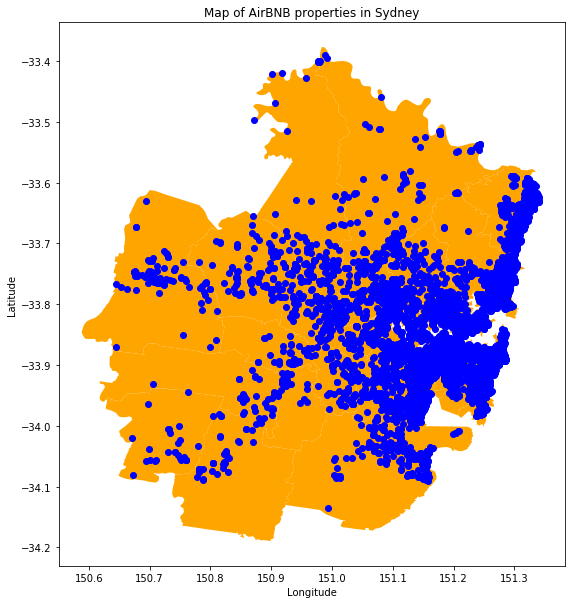

In [11]:
syd_map()

This map gives us a visualisation on just how clustered AirBNBs are in Sydney, with a majority of them being in the CBD creating an almost sea of blue dots, slowly weening off as we get farther out.

In [12]:
bins = [0,5,10,15,20,25,30,35,40,45,50,55,60]
no3 = cull_list.groupby(pd.cut(cull_list['distance'], bins=bins)).distance.count()
def bar_graph(a,ba,c,d,e,col):
    ax = a.plot(kind='bar', width = ba, color = col, figsize=(16,6))
    for p in ax.patches:
        ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    ax.set_xlabel(c)
    ax.set_ylabel(d)
    ax.set_title(e)

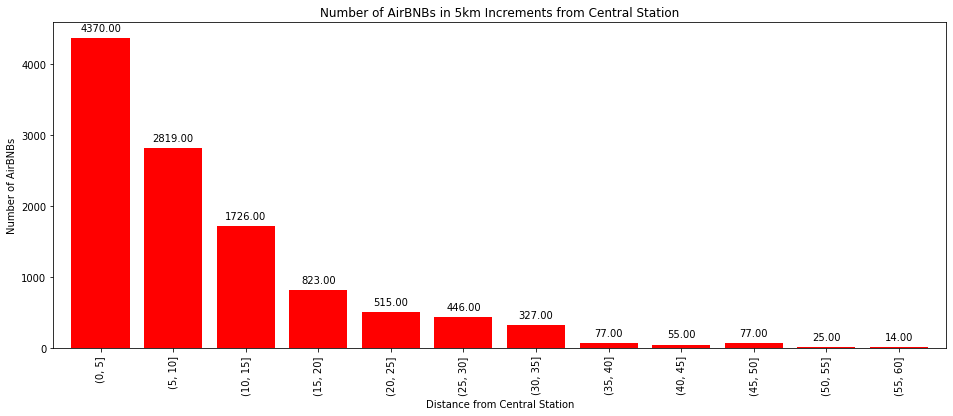

In [13]:
bar_graph(no3, 0.8, "Distance from Central Station", "Number of AirBNBs","Number of AirBNBs in 5km Increments from Central Station", "red")

The dominance of AirBNBs so close to the CBD is very easy to notice. Lets make it even easier.

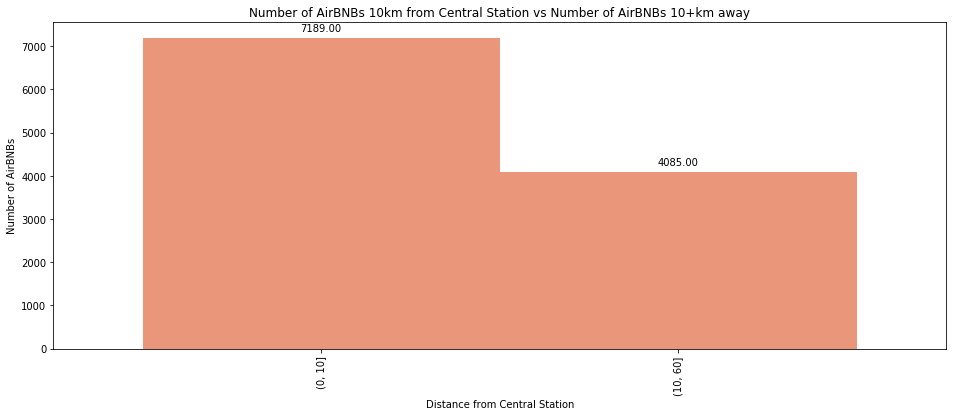

In [14]:
bins = [0,10,60]
no8 = cull_list.groupby(pd.cut(cull_list['distance'], bins=bins)).distance.count()
bar_graph(no8, 1, "Distance from Central Station", "Number of AirBNBs", "Number of AirBNBs 10km from Central Station vs Number of AirBNBs 10+km away", "darksalmon")

Just within a 10 km radius from Central, there are double the amount in the suburbs/rural area. Really shows how dominant the CBD is within the AirBNB market.

Now that we know the amount of AirBNBs around Sydney, does the location of the AirBNB actually correlate to the price  per night and popularity of the AirBNB?

Lets get a scatter plot with the distance as the X and the price as the Y. We're gonna put a limit on the Y since some people are attempting to sell their houses on AirBNB crazily enough. We're also going to make it a bubble plot by making the Z value change according to the Reviews per month to gauge popularity.

In [15]:
def bubblegraph():
    z = cull_list[["reviews_per_month"]]
    price_graph = cull_list.plot.scatter(x="distance", y="price", s=z*40, ylim=(0,2000), color="black")
    price_graph.set_xlabel("Distance from Central Station")
    price_graph.set_ylabel("Price per night")
    price_graph.set_title("Bubble Graph of Distance, Price and Reviews Per Month")

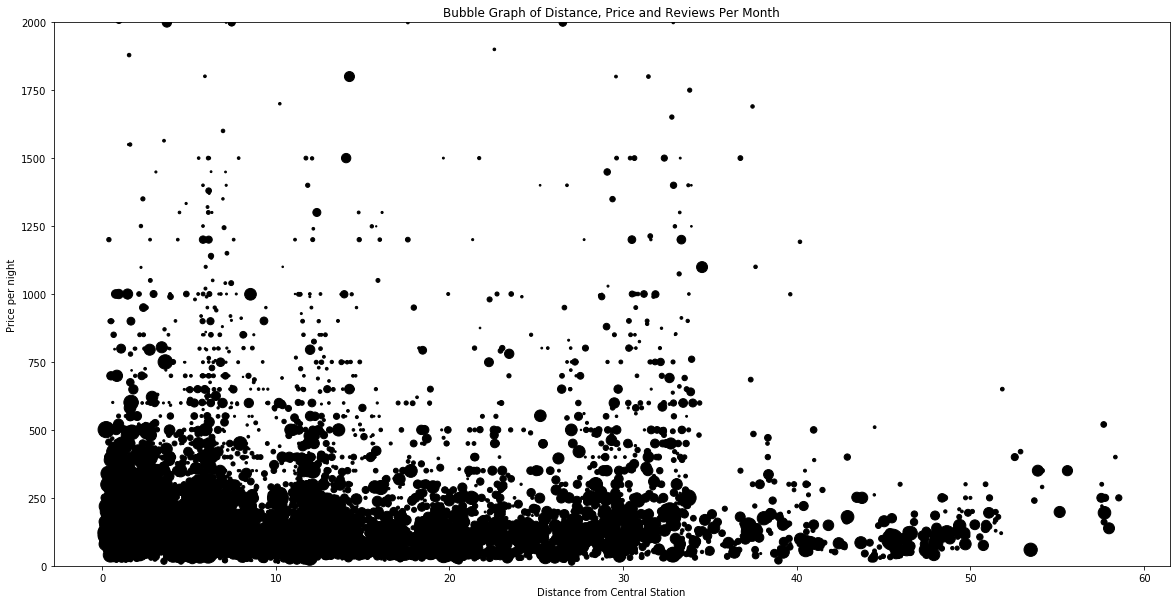

In [16]:
bubblegraph()

Just from a glance, we can see that theres no shortage of reviews per month in the suburbs and rural area, while also not having a large amount of extraordinarily expensive AirBNBs. However, between 0-30 kms, we can barely make out the difference of the bubbles due to the vast amount of under $300 AirBNBs taking up all the space. This illustrates how absolutely cutthroat this industry. Lets get an easier looking graph by creating some new dataframes.

In [17]:
al = cull_list.round({"distance": 0})
al
ak = al.groupby('distance').count() # This just counts how many entries there are overall.
avg = ak[["id"]]
ai = al.groupby('distance')["price"].sum().to_frame().reset_index() #The second string is the one that the line will mass addition for. This will also be the average of the graph.
ai['num'] = avg 
ai['Result'] = ai["price"]/ai['num']
ai

,distance,price,num,Result
0,0.0,49582,278.0,178.352518
1,1.0,246694,1277.0,193.182459
2,2.0,258831,1231.0,210.260764
3,3.0,142759,689.0,207.197388
4,4.0,106460,532.0,200.112782
5,5.0,131124,766.0,171.180157
6,6.0,330251,1204.0,274.294850
7,7.0,132159,576.0,229.442708
8,8.0,54856,312.0,175.820513
9,9.0,34080,204.0,167.058824


In [18]:
def pricegraph():
    no4 = ai.plot(x="distance", y="Result", title = "Average Price of AirBNB against the distance from Central Station", marker='o', markersize=12, linewidth=3, rot=0)
    no4.set_xlabel("Distance from Central Station (km)")
    no4.set_ylabel("Average Price ($)")

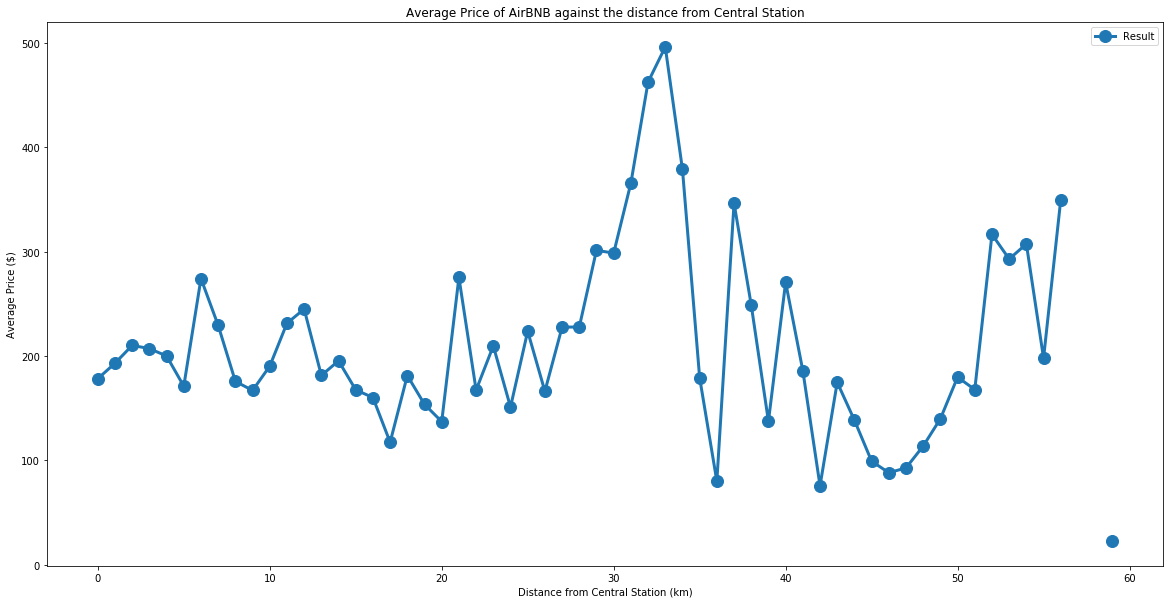

In [19]:
pricegraph()

Surprisingly enough, it seems like AirBNBs in the city arn't more expensive than more rural areas. There even seems to be a spike in average pricing around 30 kms from the CBD, with a spike to most AirBNBs being around the $500 mark. I could chalk this up to the cutthroat market of attempting to sell your place out when there is a mountain of options available. The outlier at 30ish kms can be chalked up to the lack of options around that area, and one or two people jacking up their prices per night to crazy levels.

In [20]:
al = cull_list.round({"distance": 0})
al
ak = al.groupby('distance').count() # This just counts how many entries there are overall.
avg = ak[["id"]]
ap = al.groupby('distance')["reviews_per_month"].sum().to_frame().reset_index() #The second string is the one that the line will mass addition for. This will also be the average of the graph.
ap['num'] = avg 
ap['Result'] = ap["reviews_per_month"]/ap['num']
ap

,distance,reviews_per_month,num,Result
0,0.0,496.92,278.0,1.787482
1,1.0,2259.09,1277.0,1.769060
2,2.0,1902.06,1231.0,1.545134
3,3.0,992.37,689.0,1.440305
4,4.0,627.04,532.0,1.178647
5,5.0,831.97,766.0,1.086123
6,6.0,1440.78,1204.0,1.196661
7,7.0,592.17,576.0,1.028073
8,8.0,374.84,312.0,1.201410
9,9.0,232.41,204.0,1.139265


In [21]:
def reviewplot():
    reviewplot = ap.plot(x="distance", y="Result", title = "Average Amount of monthly Reviews for AirBNBs against the distance from Central Station", marker='o', markersize=6, linewidth=3, rot=0)
    reviewplot.set_xlabel("Distance from Central Station (km)")
    reviewplot.set_ylabel("Average monthly reviews")

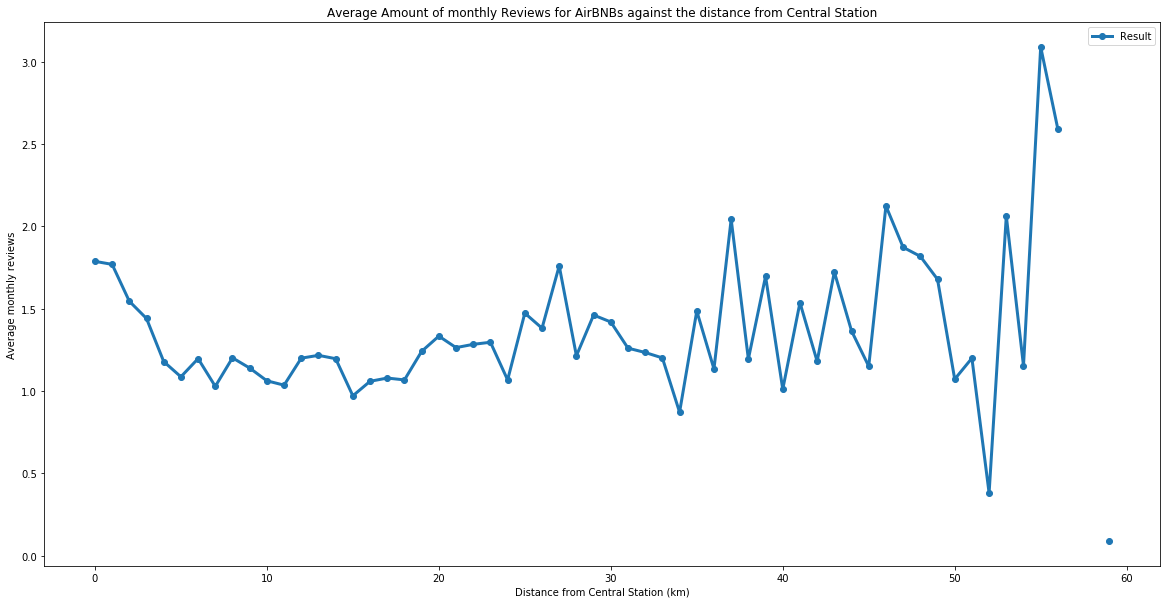

In [22]:
reviewplot()

You'd have to wonder now: Are there this many people who are able to offer their homes in the City of Sydney? We're gonna run the same code as we did previously but instead look at how many host listings each profile has.

In [23]:
al = cull_list.round({"distance": 0})
al
ak = al.groupby('distance').count()
avg = ak[["id"]]
ae = al.groupby('distance')["calculated_host_listings_count"].sum().to_frame().reset_index()
ae['num'] = avg 
ae['Result'] = ae["calculated_host_listings_count"]/ae['num']
ae


,distance,calculated_host_listings_count,num,Result
0,0.0,6339,278.0,22.802158
1,1.0,15883,1277.0,12.437745
2,2.0,22417,1231.0,18.210398
3,3.0,7379,689.0,10.709724
4,4.0,4574,532.0,8.597744
5,5.0,6230,766.0,8.133159
6,6.0,16917,1204.0,14.050664
7,7.0,6445,576.0,11.189236
8,8.0,1933,312.0,6.195513
9,9.0,796,204.0,3.901961


In [24]:
def host_graph():
    no6 = ae.plot(x="distance", y="Result", title = "Average listings of host according to AirBNB's distance from Central",marker='o', markersize=8, linewidth=3, color="brown", rot=0)
    no6.set_xlabel("Distance from Central Station (km)")
    no6.set_ylabel("Average Listings from Host")

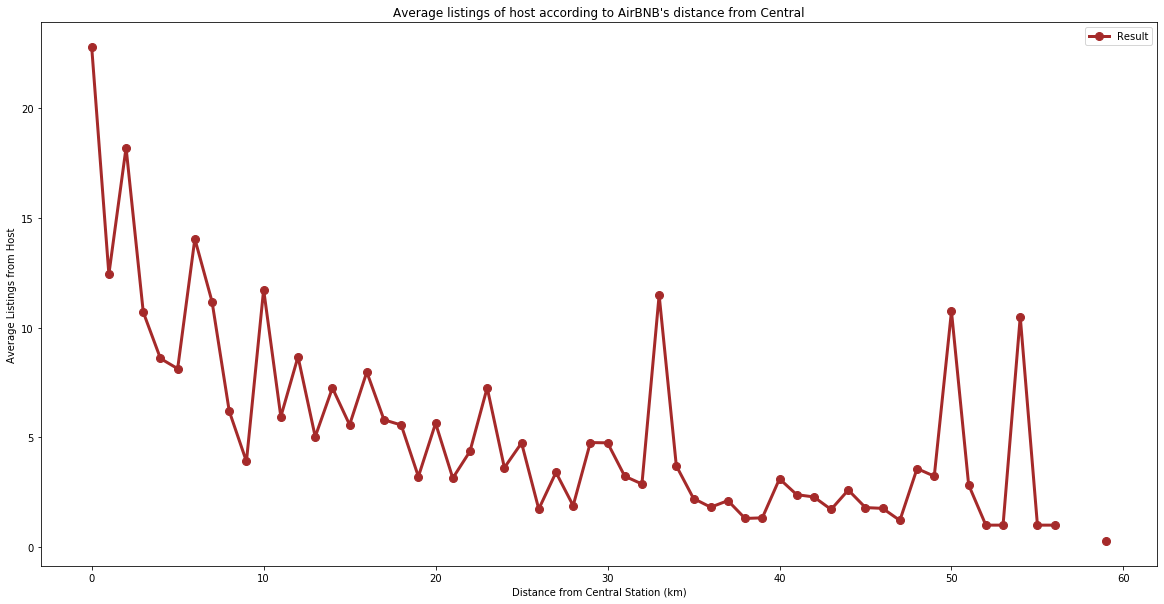

In [25]:
host_graph()

This is the most telling graph, with a majority of hosts within the 10km radius of the CBD on average hosting 10 or more properties 

## The Popularity of specific neighbourhoods and suburbs

We're gonna look at the suburbs/neighbourhoods now and their popularity. Our main metric for popularit will be reviews per month, which isn't the best metric as that can be tampered with by the owner's availability, but it is the closest we will get to gauging popularity.

This dataset doesn't gather the average rating of an AirBNB as well, so we're going to be gauging popularity through the number of monthly reviews and overall reviews.

Our first order of business is making a dataframe that has the number of entries in the specific neighbourhood, the number of reviews overall and the monthly reviews as well. 

In [26]:
au = al.groupby('neighbourhood').count()
au.rename(columns={'id': 'number_of_entries'}, inplace=True)
new_num = au[["number_of_entries"]]
yy = cull_list.groupby(['neighbourhood']).agg(["sum"])

au["number_of_reviews"] = yy.iloc[:, [7]]
au["number_of_monthly_reviews"] = yy.iloc[:, [9]]
au["coollat"] = yy.iloc[:, [2]]
au["coollong"] = yy.iloc[:,[3]]
au["average_numberofreviews"] = au["number_of_reviews"]/au["number_of_entries"]
au["average_numberof_monthly_reviews"] = au["number_of_monthly_reviews"]/au["number_of_entries"]
au["location_latitude"] = au["coollat"]/au["number_of_entries"]
au["location_longitude"] = au["coollong"]/au["number_of_entries"]
au.head(5)

,number_of_entries,name,host_id,host_name,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,...,availability_365,distance,geometry,number_of_monthly_reviews,coollat,coollong,average_numberofreviews,average_numberof_monthly_reviews,location_latitude,location_longitude
neighbourhood,,,,,,,,,,,,,,,,,,,,,
Ashfield,81,81,81,81,81,81,81,81,81,156.0,...,81,81,81,87.30,-2744.90081,12241.38377,1.925926,1.077778,-33.887664,151.128195
Auburn,187,187,187,187,187,187,187,187,187,523.0,...,187,187,187,302.35,-6329.05601,28248.82880,2.796791,1.616845,-33.845219,151.063256
Bankstown,126,126,126,126,126,126,126,126,126,180.0,...,126,126,126,140.05,-4274.23957,19029.19371,1.428571,1.111508,-33.922536,151.025347
Blacktown,125,125,125,125,125,125,125,125,125,241.0,...,125,125,125,152.89,-4218.43455,18861.32911,1.928000,1.223120,-33.747476,150.890633
Botany Bay,179,179,179,179,179,179,179,179,179,591.0,...,179,179,179,310.32,-6073.89106,27064.61622,3.301676,1.733631,-33.932352,151.198973


Let's get a visualisation of the neighbourhoods on a map before we begin.

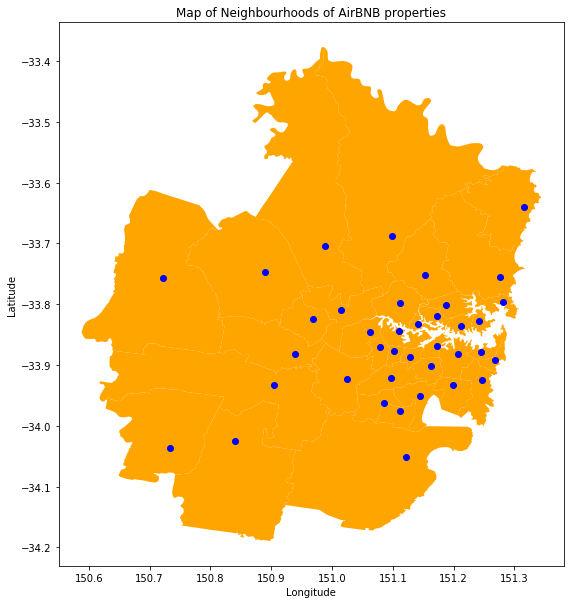

In [27]:
of = gpd.GeoDataFrame(
    au, geometry=gpd.points_from_xy(au.location_longitude, au.location_latitude))
ax = df_places.plot(color='orange')
of.plot(ax=ax, color='blue')
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Map of Neighbourhoods of AirBNB properties")
plt.show()

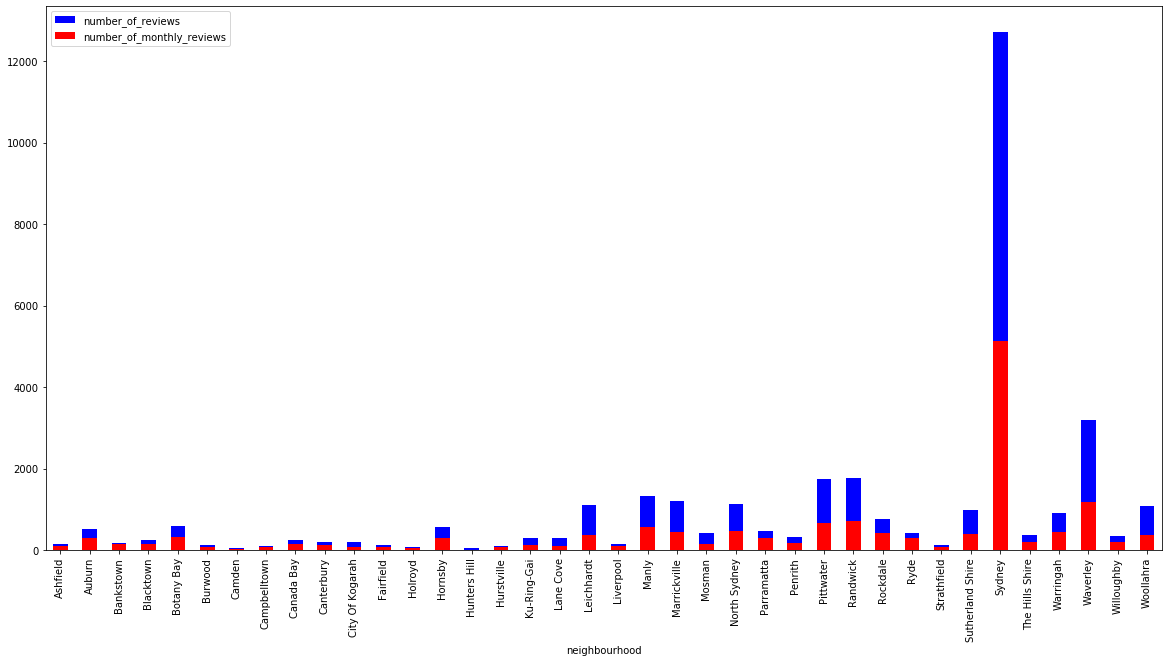

In [28]:
ao = plt.gca()
au.plot.bar(y="number_of_reviews", color="blue", ax = ao)
au.plot.bar(y="number_of_monthly_reviews", color= "red", ax = ao)

Well, we already knew the city was crowded but this doesn't help us at all! Lets remove the CBD from the dataframe to make this easier for us to see our results.

In [29]:
def neighbourhoodg():
    jk = au.drop(["Sydney"])
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
              '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    ao = plt.gca()
    jk.plot.bar(y="number_of_reviews", color="blue", ax = ao)
    jk.plot.bar(y="number_of_monthly_reviews", color= "red", ax = ao)

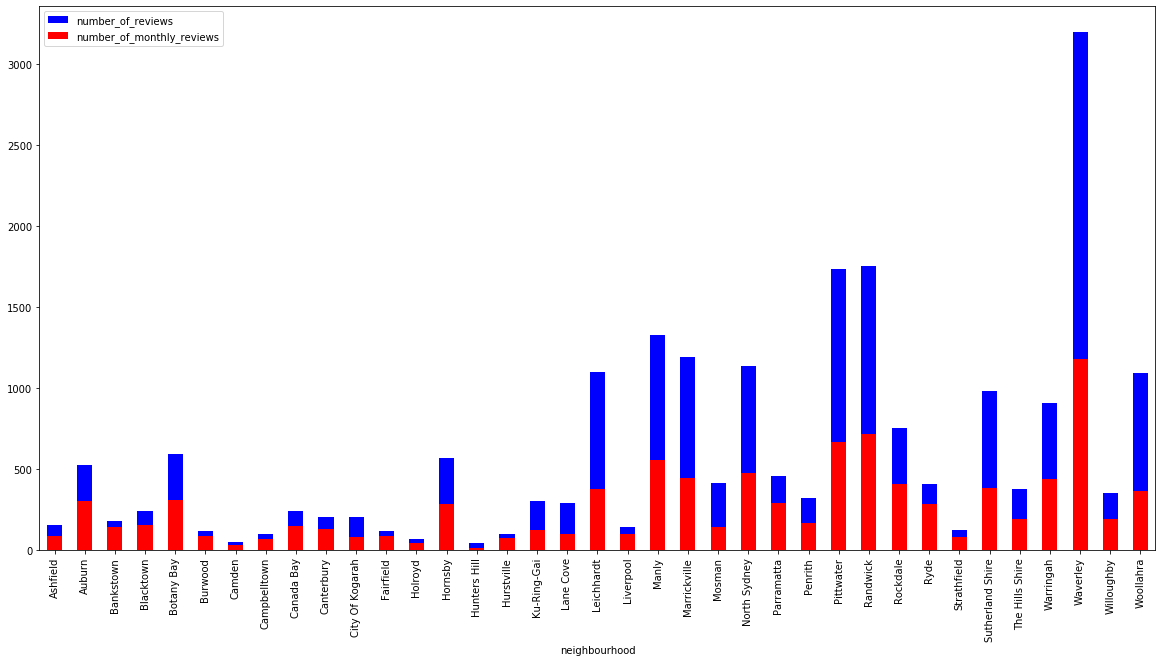

In [30]:
neighbourhoodg()

The most American  graph. As expected, the locations close by to the city are quite popular, however some neighbourhoods such as Hornsby and Auburn are actually quite popular. Note that this data is just a year old, so legacy listings (listings that haven't been up listed or reviewed in the past year) are not included. 

There's still a bit of bias since some locations still have more listings, so lets get the average to see what place gets the most amount of reviews against the amount of listings.

In [31]:
def avg_graph():
    jk = au.drop(["Sydney"])
    ao = plt.gca()
    jk.plot.bar(y="average_numberofreviews", color="green", ax = ao)
    jk.plot.bar(y="average_numberof_monthly_reviews", color= "yellow", ax = ao)

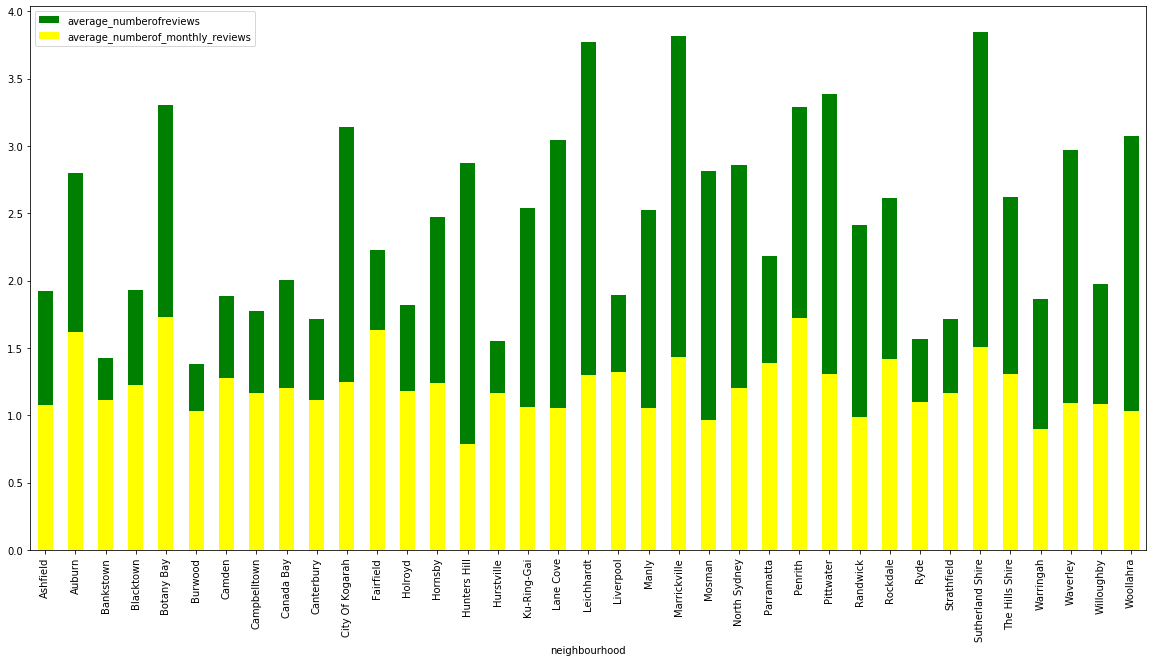

In [32]:
avg_graph()

Brazil. Nice. Now with this graph, we can see what neighbourhood gets the most reviews without considering how some neighbourhoods will have more AirBNBs than others, while also being able to see the neighbourhoods that are rising in popularity.  

* Places like Fairfield, Camden or Ryde seem to be rising in popularity, with the amount of Avg.Monthly Reviews being comparable to the historically good neighbourhoods such as Sutherland Shire and Marrickville.
* This also shows how some places are falling in popularity, such as Ku-Ring-Gai and Leichhardt with them historically being quite popular before.